In [1]:
# 🟠 Environment & Kaggle Setup (Colab-specific)

# from google.colab import files
# files.upload()  # Manually upload kaggle.json

In [2]:
import os

# Set Kaggle username and key from environment variables
os.environ['KAGGLE_USERNAME'] = 'username'
os.environ['KAGGLE_KEY'] = 'key'

In [3]:
# Download dataset from Kaggle using the command line
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
# Unzip the downloaded dataset quietly (-q) and overwrite existing files (-o)
!unzip -qo lung-and-colon-cancer-histopathological-images.zip
print('✅ Dataset extracted.')

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
lung-and-colon-cancer-histopathological-images.zip: Skipping, found more recently modified local copy (use --force to force download)
✅ Dataset extracted.


In [4]:
# !pip install -q kaggle opencv-python tensorflow
# Install necessary libraries quietly if not already installed

# 1. Importing Libraries

In [5]:
# 🔧 Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import cv2
import gc
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn import metrics

- The dataset used for this project is available from Kaggle and it consists of 5,000 images belonging to three categories of lung conditions:
	- Normal Class
	- Lung Adenocarcinomas
	- Lung Squamous Cell Carcinomas
- This dataset has already been augmented meaning, the 250 images for each category were artificially expanded so we won’t need to perform Data Augmentation ourselves.

In [6]:
# List the contents of the lung image sets directory to see the class folders
import os
print(os.listdir('./lung_colon_image_set/lung_image_sets'))

['lung_n', 'lung_aca', 'lung_scc']


- Classes will contain the names: 'lung_n', 'lung_aca' and 'lung_scc' corresponding to Normal, Lung Adenocarcinoma and Lung Squamous Cell Carcinoma

In [7]:
# 📂 Dataset Paths
# Define paths for lung and colon image sets
path_lung = './lung_colon_image_set/lung_image_sets'
path_colon = './lung_colon_image_set/colon_image_sets'

classes = []
# Check if lung path exists and add its subdirectories (classes) to the list
if os.path.exists(path_lung):
    classes.extend([d for d in os.listdir(path_lung) if os.path.isdir(os.path.join(path_lung, d))])
# Check if colon path exists and add its subdirectories (classes) to the list
if os.path.exists(path_colon):
    classes.extend([d for d in os.listdir(path_colon) if os.path.isdir(os.path.join(path_colon, d))])
print("🔍 Detected Classes:", classes)

🔍 Detected Classes: ['lung_n', 'lung_aca', 'lung_scc', 'colon_n', 'colon_aca']


# 3. Visualizing the Data

lung_n: 250 images loaded


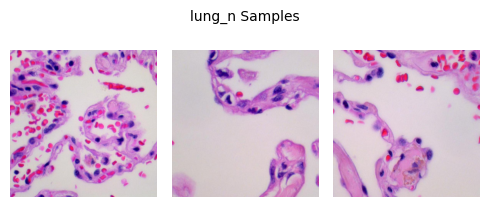

lung_aca: 250 images loaded


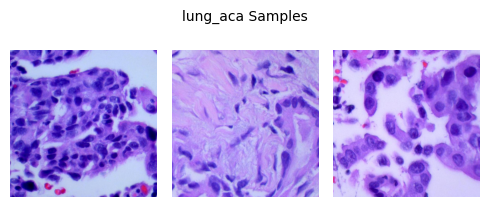

lung_scc: 250 images loaded


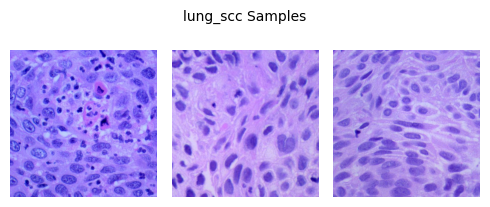

colon_n: 250 images loaded


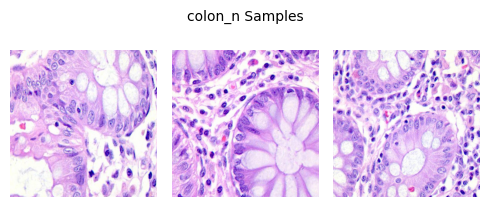

colon_aca: 250 images loaded


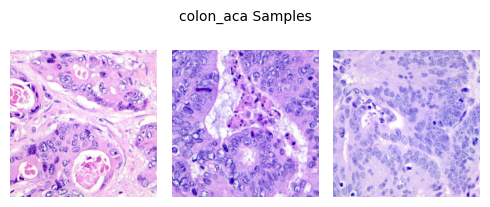


📦 Total images loaded: 1250


In [8]:
# 🖼️ Visualization of Samples
total_images = 0
# Iterate through each detected class
for cat in classes:
    # Determine the image directory based on whether the class is lung or colon
    image_dir = f'{path_lung}/{cat}' if cat.startswith('lung') else f'{path_colon}/{cat}'
    # Skip if the directory does not exist
    if not os.path.exists(image_dir):
        continue
    # Get a list of images in the directory, limited to the first 250
    images = sorted(os.listdir(image_dir))[:250]
    count = len(images)
    total_images += count
    print(f"{cat}: {count} images loaded")

    # Create a figure and subplots to display sample images
    fig, ax = plt.subplots(1, 3, figsize=(5, 5))
    fig.suptitle(f'{cat} Samples', fontsize=10, y=0.70)
    plt.subplots_adjust(top=0.85, wspace=0.2)
    # Display 3 random images from the class
    for i in range(3):
        k = np.random.randint(0, count)
        img = np.array(Image.open(f'{image_dir}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()
print(f"\n📦 Total images loaded: {total_images}")

# 4. Preparing the Dataset:
- Resizing the images and convert them into the numpy arrays for efficient computation
- Image Resizing: Since large images are computationally expensive to process we resize them to a standard size (128x128) using numpy array. We used 10 epochs with batch size of 32.
- One Hot Encoding: Labels (Y) are converted to one-hot encoded vectors using pd.get_dummies(). This allows the model to output soft probabilities for each class.

In [9]:
# 🧼 Data Preparation
IMG_SIZE = 64 # Define the target image size
SPLIT = 0.2 # Define the split ratio for validation data
EPOCHS = 10 # Define the number of training epochs
BATCH_SIZE = 32 # Define the batch size for training

X = [] # List to store image data
Y = [] # List to store image labels

# Iterate through each class to load and process images
for i, cat in enumerate(classes):
    # Determine the image directory based on the class
    image_dir = path_lung if cat.startswith('lung') else path_colon
    # Get all jpeg image paths for the current class
    image_paths = glob(f'{image_dir}/{cat}/*.jpeg')
    # Process each image
    for image in image_paths:
        img = cv2.imread(image)
        # Resize the image if it's loaded successfully
        if img is not None:
            resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(resized)
            Y.append(i) # Append the class index as the label

# Convert the image data and labels to numpy arrays
X = np.asarray(X)
# Perform one-hot encoding on the labels
Y_encoded = pd.get_dummies(Y).values

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y_encoded, test_size=SPLIT, random_state=42)

# 5. Model Development:
- Sequential(): Builds a linear stack of layers.
- Conv2D(): Applies convolution with specified filters, kernel size, ReLU activation and padding.
- MaxPooling2D(): Downsamples feature maps by taking max values over pool size.
- Flatten(): Converts 2D feature maps into 1D vector.
- Dense(): Fully connected layer with given units and activation.
- BatchNormalization(): Normalizes activations to speed up training.
- Dropout(): Randomly drops neurons to reduce overfitting.
- model.summary(): Displays model architecture details.



In [10]:
# 🧠 CNN Model
# Define the CNN model using Keras Sequential API
model = keras.models.Sequential([
    # Convolutional layer with 16 filters, 3x3 kernel, ReLU activation, and same padding
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Max pooling layer with 2x2 pool size
    layers.MaxPooling2D(2, 2),
    # Another convolutional layer with 32 filters
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Another max pooling layer
    layers.MaxPooling2D(2, 2),
    # Another convolutional layer with 64 filters
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # Another max pooling layer
    layers.MaxPooling2D(2, 2),
    # Flatten the output from convolutional layers
    layers.Flatten(),
    # Dense layer with 128 units and ReLU activation
    layers.Dense(128, activation='relu'),
    # Batch normalization layer
    layers.BatchNormalization(),
    # Dropout layer with a rate of 0.3 to reduce overfitting
    layers.Dropout(0.3),
    # Dense layer with 256 units and ReLU activation
    layers.Dense(256, activation='relu'),
    # Batch normalization layer
    layers.BatchNormalization(),
    # Dropout layer with a rate of 0.3 to reduce overfitting
    layers.Dropout(0.3),
    # Output dense layer with a number of units equal to the number of classes and softmax activation
    layers.Dense(len(classes), activation='softmax')
])
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 583,845 (2.23 MB)

 Trainable params: 583,077 (2.22 MB)

 Non-trainable params: 768 (3.00 KB)

# 6. Model Compilation:
- After defining the model architecture we will compile the model with an optimizer, loss function and evaluation metric then train it using the training data.

- We use the Adam optimizer which adjusts the learning rate during training to speed up convergence.
- Categorical cross entropy loss is appropriate as loss function for multi-class classification problems as it measures the difference between the predicted and actual probability distributions.
- EarlyStopping: Stops training if validation accuracy doesn’t improve for a set number of epochs (patience).
- ReduceLROnPlateau: Reduces learning rate when validation loss plateaus, controlled by patience and factor.
- Custom myCallback class: Stops training early when validation accuracy exceeds 90%.
- self.model.stop_training = True: Signals to stop training inside the callback.

In [11]:
# ⏳ Training Setup
# Custom callback to stop training when validation accuracy reaches 90%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.90:
            print('\n✅ Validation accuracy > 90%, stopping training.')
            self.model.stop_training = True

# Early stopping callback to stop training if validation accuracy doesn't improve for 3 epochs
es = keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
# Reduce learning rate callback to reduce learning rate when validation loss plateaus
lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 7. Model Training
- Now we will train our model by defining the following:

- model.fit() trains the model on training data X_train and Y_train.
- validation_data provides validation inputs X_val and Y_val for evaluation each epoch.
- batch_size sets the number of samples per training batch.
- epochs defines how many times the model iterates over the entire training set.
- verbose=1 displays training progress.
- callbacks includes early stopping, learning rate reduction and custom callback to control training based on validation metrics.

In [12]:
# 🏃‍♂️ Model Training
# Train the model using the training data and validate with the validation data
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, lr, myCallback()], # Include the defined callbacks
    verbose=1 # Display training progress
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 143ms/step - accuracy: 0.7599 - loss: 0.6034 - val_accuracy: 0.2108 - val_loss: 12.6484 - learning_rate: 0.0010
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.8031 - loss: 0.4695 - val_accuracy: 0.2086 - val_loss: 8.8345 - learning_rate: 0.0010
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 136ms/step - accuracy: 0.8162 - loss: 0.4425 - val_accuracy: 0.3948 - val_loss: 6.8312 - learning_rate: 0.0010
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.8518 - loss: 0.3592 - val_accuracy: 0.6554 - val_loss: 1.1348 - learning_rate: 0.0010
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 136ms/step - accuracy: 0.8792 - loss: 0.3015 - val_accuracy: 0.6754 - val_loss: 1.6574 - learning_rate: 0.0010
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8860 - loss: 0.2873
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - accuracy: 0.88

# 8. Visualizing
- Let's visualize the training and validation accuracy with each epoch.

- pd.DataFrame(history.history) converts training history into a DataFrame.
- history_df.loc[:, ['accuracy', 'val_accuracy']].plot() plots training and validation accuracy.

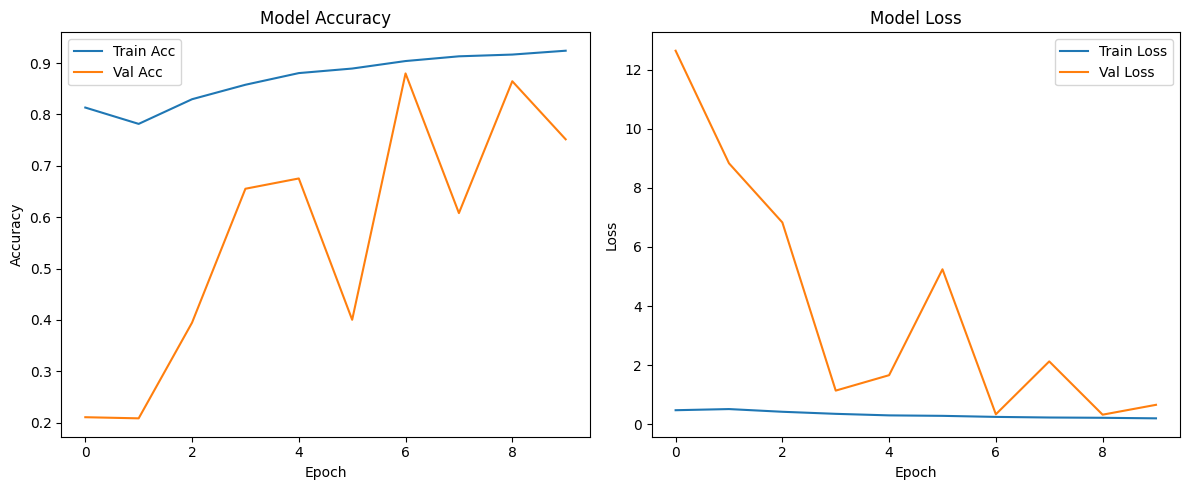

In [13]:
# 📊 Plot Accuracy & Loss
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

8. Model Evaluation
- Now as we have our model ready let's evaluate its performance on the validation data using different metrics. For this we will first predict the class for the validation data using this model and then compare the output with the true labels.

- model.predict(X_val) generates predictions for validation data.
- np.argmax(Y_val, axis=1) converts one-hot encoded true labels to class indices.
- np.argmax(Y_pred, axis=1) converts predicted probabilities to class indices.
- metrics.classification_report() prints precision, recall, f1-score and support for each class.

In [14]:
# 🔍 Evaluation
# Predict the classes for the validation data
Y_pred = model.predict(X_val)
# Convert predicted probabilities to class indices
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert one-hot encoded true labels to class indices
Y_true_classes = np.argmax(Y_val, axis=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


- metrics.classification_report() displays detailed evaluation metrics for each class based on true (Y_val) and predicted (Y_pred) labels, using class names from classes.

In [15]:
# Print the classification report to evaluate model performance
# The report includes precision, recall, f1-score, and support for each class
print(metrics.classification_report(Y_true_classes, Y_pred_classes, target_names=classes))

              precision    recall  f1-score   support

      lung_n       0.96      1.00      0.98      1021
    lung_aca       0.90      0.88      0.89      1000
    lung_scc       0.95      0.87      0.91       985
     colon_n       0.74      1.00      0.85       989
   colon_aca       0.90      0.66      0.76      1005

    accuracy                           0.88      5000
   macro avg       0.89      0.88      0.88      5000
weighted avg       0.89      0.88      0.88      5000



- The classification report shows that the model performs well on normal lung tissue (lung_n) with high precision and recall resulting in a strong F1-score. However it struggles with lung_aca (lung adenocarcinoma) and lung_scc (lung squamous cell carcinoma) particularly in terms of recall. It tells us that model can be improved in handling imbalanced classes and enhancing performance across all categories.

